# Simple Moving Average Crossover Strategy

Author: Marcello Chiuminatto

Python version: 3.10.4

## Overview

In the context of FOREX trading, in the commitment for finding profitable trading strategies, you will find in books, articles, papers, web sites and maybe from your own inspiration, strategies that shows positive profits, based on cumulative profit over a period. Well, that is not enough unfortunately, because does not necessarily indicate consistency in the profits.

Would be profit average (expected profit) then be a good indicator of profits consistency? The answer is not straight forward: not necessarily. Why? and the answer to this question is the topic of this publication: Outliers. 

Outliers will distort the reading of cumulative profits and expected profits in such a way that a losing strategy, can look like a profitable one.

Consider the following example:
Let's define a strategy S, from which we get a sample of 50 trades whose profits are distributed as shown in the next table:



|        |Trades | Profit/trade[pips] |Total Profit[pips]|
|--------| ------|--------------------|------------------|
|        |  25   |   -5.0             |        -125.0    |    
|        |  24   |   2.0              |          48.0    |
|        |  1    |  200.0             |         200.0    |
|--------|-------|--------------------|-------------------
| Total  |  50   |                    |         123.0    |
| mean   |       |                    |         2.5      |
| median |       |                    |         -1.5     |



Total profit and average profit are positive, but clearly this is strongly influenced by the 200 pip trade. Pay close attention to median though, is telling something about this case.

Based on a real but simple trading strategy, how outliers impacts mean and total profits, but median.

Throughout this article, it will be shown with a real, but simple trading strategy, the danger of not paying attention to outliers and in the process of showing so, presents the process of a trading strategy definition: design / vectorized back-testing, analysis, and conclusions.

## Strategy Design

### Definition and Concepts

This strategy is one of the simplest trend-following or momentum FOREX trading strategy.

For simplicity, this analysis focusses only on buying (long) strategy.

The rationale behind the strategy is the following: *“When price “accelerates” enough to the upside it is likely that will remain that way for a while, so is a good signal for opening a buying position and keep it open until market decelerate.”*

To have an actionable and testable strategy is necessary to define in mathematical terms the concepts involved in the above statement: acceleration and deceleration. It necessary to remark that these concepts are defined in the context of this trading strategy analysis only and under no way are general concepts that can necessarily be applied to ALL trading strategies or financial markets.

Being that said and reducing the abstraction level a bit, market acceleration is defined as: when prices close above a fast-moving average, which is above a medium-moving average, which at the same time is above a slow-moving average.

Market deceleration is defined as: when the fast-moving average close below the medium-moving average.

**What is a Moving Average (MA) of $n$ periods?**

It is the average of the last $n$ available price periods. Generally, is calculated on close price (which is the case for this research), but can also be calculated on open, high, low, typical price etc.)


Mathematically:

$MA(close;n)=\frac{1}{n}\sum_{i=t-n+1}^{i=0} close_i$


*Simple moving average on close parametrized with n (periods)*

Where:

- $n$ Number of periods
- $close_i$: close price at i-th period


*What are fast, medium and slow moving averages?*

The concept of speed for a MA's is given by the number of periods the MA is calculated on; less number periods will make the MA to react *faster* to price action whilst greater number of periods will make it *slower*.

In this context the periods for the three different MA are defined as follows:

* Fast MA ($MA_f$): 10 periods
* Medium MA ($MA_m$): 25 periods
* Slow MA ($MA_s$): 50 periods


### Long entry/exit rules

Now it is time to concretely define the strategy Entry/Exit/Management rules.

 **Entry**<br><br>
  Enter long when close cross above $SMA_f$ and $SMA_f$ is above $SMA_m$ and $SMA_m$ is above $SMA_s$
  
  Mathematically:
  
  Enter long when the following two conditions are true
  
  1. $close_{t-1}<SMA_f \land close_t > SMA_f$
  2. $SMA_s < SMA_m < SMA_f$
 
  **Exit**<br><br> 
  Exit a long position when $SMA_f$ cross below $SMA_m$

  Mathematically

  Exit when
  1. $SMA_f<SMA_m$

<img src="./long_setup_example.png">

Example


## Strategy Back-testing

Strategy back-testing is in essence simulating the strategy logic on historic data, expecting that past performance will repeat in the feature. But this is not necessarily the case and depends a lot on how the back-testing process is designed and executed, among other conditions. Detailed back-testing discussion is out of the scope of this analysis. As a starter you can find more here: https://www.investopedia.com/terms/b/backtesting.asp.

What is relevant for this analysis is that back-testing will produce a set of trades that if considered right out of the process they seem to be produced by a profitable strategy, but hypothetically this is not true and the real losing results are hidden by outliers.

In this section are presented some steps to implement a simple *vectorized* back-testing process. The term **vectrorized** means that instead of looping throughout the elements of an array or a matrix performing scalar operations, the operations are performed on entire arrays or matrices (vectors). Why to do so? because the reduction of processing time is significant, specially when working with millions or billions of records. You can find more here: https://www.youtube.com/watch?v=BR3Qx9AVHZE






### Imports

In [1]:
%run support_code.py

### Global Variables

In [2]:
SMA_fast = 10
SMA_med = 25
SMA_slow = 50

COL_f = f'SMA_{SMA_fast}'
COL_m = f'SMA_{SMA_med}'
COL_s = f'SMA_{SMA_slow}'

PLOT_FROM = 2000
PLOT_TO = 2200

SYMBOL='EURUSD=X'

DIGITS = 4  # digits where the pip change is counted
if 'JPY' in SYMBOL:
    DIGITS=2
    
PIP_FACTOR = 10**DIGITS  # factor to convert from points change to pip change

TRADE_COST = 0.5  # estimated spread + commission per trade


### Load Data

In [3]:
df = pd.read_csv('EURUSD_Hourly_Bid_2015.01.01_2021.11.24.csv')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)']) 
df.set_index('Time (UTC)', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Time (UTC),,,,,
2015-01-01 22:00:00,1.21038,1.21073,1.20999,1.21014,1069.99
2015-01-01 23:00:00,1.21015,1.21020,1.20783,1.20869,4662.40
2015-01-02 00:00:00,1.20871,1.20890,1.20668,1.20674,3886.31
2015-01-02 01:00:00,1.20675,1.20723,1.20519,1.20670,6203.48
2015-01-02 02:00:00,1.20670,1.20687,1.20476,1.20588,4255.56


In [4]:
# Downlaod data from yahoo finance using yfinance library
# Uncomment of you want to try different symbols

# df = yf.download(SYMBOL, 
#                       start='2020-01-01', 
#                       end='2021-12-31', 
#                       interval='1h',
#                       progress=False)
# df.head()

Records  42988


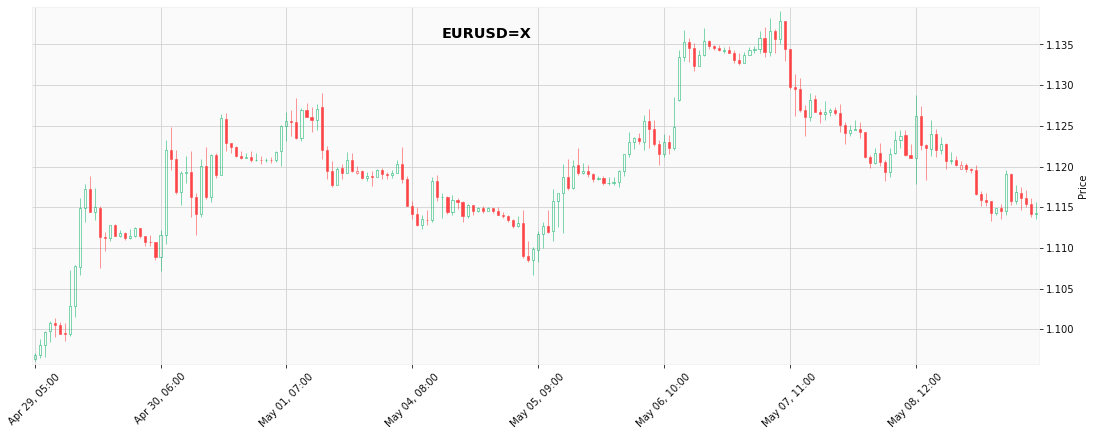

In [5]:
print('Records ', df.shape[0])
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5),
         title=SYMBOL)

### Feature Calculation

Calculate $SMA_10$, $SMA_25$ and $SMA_50$ using pandas rolling windows

In [6]:
df[COL_f] = df['Close'].rolling(SMA_fast).mean()
df[COL_m] = df['Close'].rolling(SMA_med).mean()
df[COL_s] = df['Close'].rolling(SMA_slow).mean()
df.dropna(inplace=True)

In [7]:
ap0 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
       mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green')]

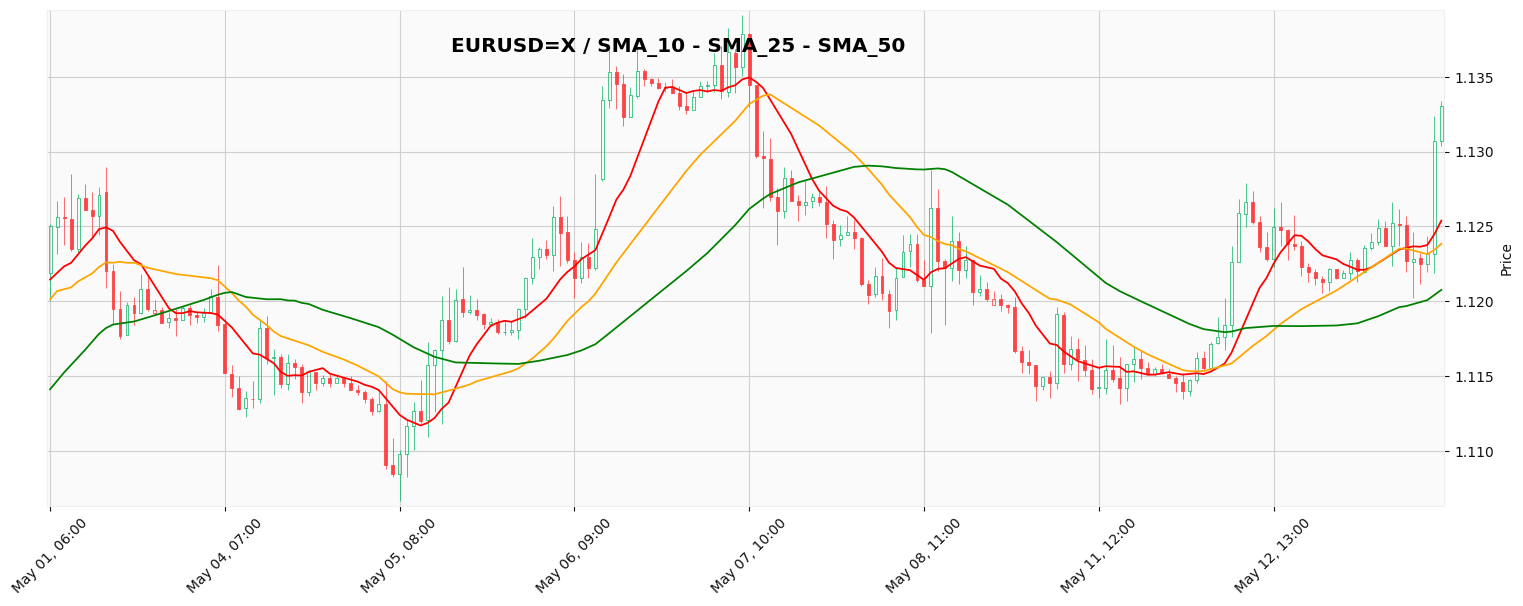

In [8]:
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap0, title=f'{SYMBOL} / {COL_f} - {COL_m} - {COL_s}')

### Strategy Vectorization

The strategy vectorization requires the following steps:

* Mark entry and exit signal
* Mark trading periods
* Reduce trading periods to trades
* Calculate profits

These steps that are followed here are not mandatory and can and probably will change from strategy to strategy, from trader to trader and for many other reasons.

#### Mark Entry and Exit Signal

Special care need to be taken when  marking entry and exit events. Since a signal is marked once the period or bar is closed, you MUST mark the entry period right at the opening of next bar. 

<b>Entry Signal: Cross over condition</b>

The entry signal is triggered when the last available close price crosses above the fast SMA, along with fast SMA being above med SMA and med SMA being above the slow SMA.


$signal_i = (open_{i} < SMA_{fast, i} < close_{i})  \land (SMA_{slow, i} < SMA_{med, i} < SMA_{fast, i})$

Where:

* $Close_{i}$: Last closed bar close price.
* $Open_{i}$: Last closed bar open price.
* $SMA_{fast, i}, SMA_{med, i}, SMA_{slow, i}$: SMA fast, med and slow respectively, calculated at the last bar close.


<b>Entry period</b>

The entry period is marked right at the opening of current bar, if signal was risen for the last closed bar.


$entry_i=\begin{cases}
    1 \text{ if }signal_{i-1} = True\\
    \emptyset \text{ otherwise}
\end{cases}
$

Where:

* $entry_i$: Indicates if a trade needs to be opened at current period.
* $signal_{i-1}:$ Signal at last closed bar.


<b>Exit Signal</b>

The exit signal is given when the close price crosses below the med SMA, therefore, following the entry signal/entry condition logic, the exit signal is risen right at the opening of current bar.

<b>Exit Signal</b>

$x\_signal_i = close_{i} < SMA_{med, i} < open_i$

<b>Exit Signal</b>

$exit_i = \begin{cases}
    -1 \text{ if }x\_signal_{i-1} = True \\
    \emptyset \text{ otherwise}
\end{cases}
$

In the example below:


<img src="VectoriationExample.png" width="400"> </img>


- $t=2$: entry signal risen at the close of 2nd bar.
- $t=3$: entry condition is met, so a long trade is open right at the opening of the 3rd bar.
- $t=6$: exit signal is risen at the close of 6th bar.
- $t=7$: exit condition is met, so the trade is closed right at the opening of the 7th bar.


#### Mark Entry and Exit Signal

In [9]:
df['trade'] = np.nan
df['signal'] = np.nan
df['entry'] = np.nan
df['exit'] = np.nan


from SignalLib.Signal import Signal


# define entry signal condition
mask_signal =    (df['Close'] > df[COL_f]) & (df['Open'] < df[COL_f]) & \
                 (df[COL_f] > df[COL_m]) &  (df[COL_m] > df[COL_s]) # SMA positioning

#define exit signal condition
mask_x_signal = (df['Close'] < df[COL_m]) & (df['Open'] >  df[COL_m])


print("df shape ", df.shape, "entry shape ", mask_signal.shape, "exit shape ", mask_x_signal.shape)
sig_calc = Signal()

singnal_col = sig_calc.compute(df, mask_signal, mask_x_signal)

# plotting adjustments
df.loc[(df['signal']==1), 'plot_signal'] = df[COL_s] - 0.0010
df.loc[(df['signal']==-1), 'x_plot_signal'] = df['High'] + 0.0010


df shape  (42939, 12) entry shape  (42939,) exit shape  (42939,)


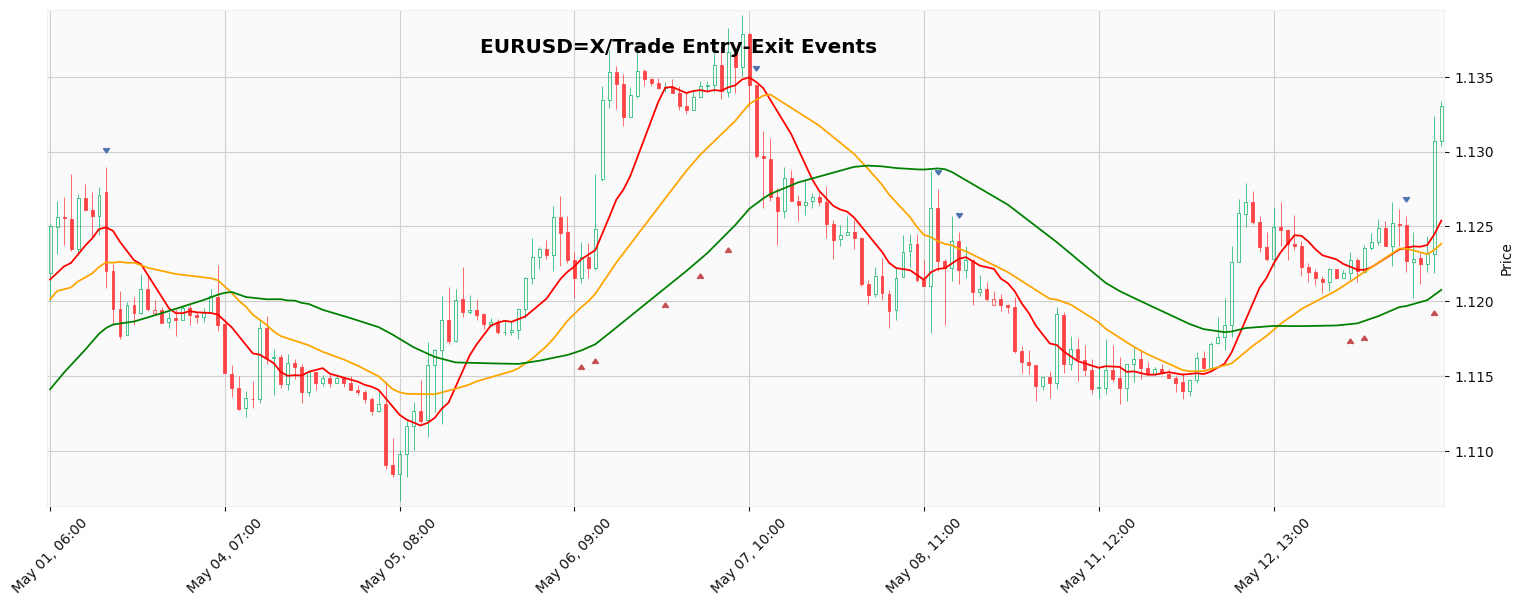

In [10]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_signal'],type='scatter', marker=6, color="r"),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['x_plot_signal'],type='scatter', marker=7, color="b"),
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

#### Mark Entry/Exit condition

#### Mark Trades

In [11]:
from Trades.Trades import MarkDiscontinuous

_trades = MarkDiscontinuous(4)
df = _trades.mark_trades(df, singnal_col)

In [12]:
# prepare plotting columns
mask_trade = df['trade'].isna()
df.loc[~mask_trade, 'plot_trade'] = df.loc[~mask_trade][COL_s] - 0.0005

In [13]:
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]][2190:2200]
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]].to_csv("bench_trades.csv")
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]].to_csv("trades_periods.csv")

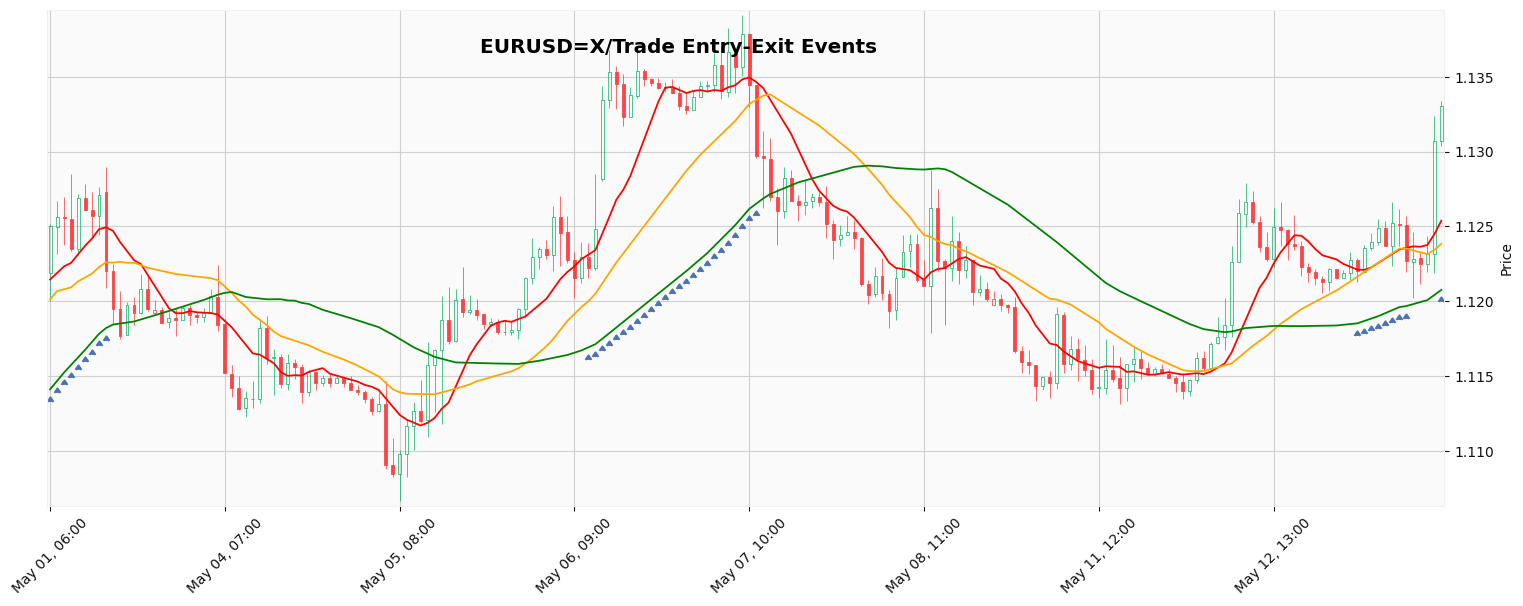

In [14]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_trade'],type='scatter', marker=6, color="b")
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

#### Calculate Profit [pips]

In [15]:
def profit_report_col(df, column='net_profit'):

        # NON FILTERED
        _mask_tot = df[column] !=0
        _tot_trades = len(df[_mask_tot])

        _mask_win_trades = df[column] > 0
        _tot_win_trades = len(df[_mask_win_trades])
        _tot_win_pft = df[_mask_win_trades][column].sum().round(2)

        _mask_los_trades = df[column] < 0
        _tot_los_trades = len(df[_mask_los_trades])
        _tot_loss_pft = df[_mask_los_trades][column].sum().round(2)

        _total_pft = df[column].sum().round(2)
        _mean_pft = df[column].mean().round(2)
        _std_pft = df[column].std().round(2)
        
        _median_pft = df[column].median().round(2)
        _mode_pft = df[column].mode().round(2)
        
        _skew_pft = df[column].skew().round(2)

        _report = dict()
        _report['column'] = column
        _report['tot_trades'] = _tot_trades
        _report['tot_win_trades'] = _tot_win_trades
        _report['tot_losing_trades'] = _tot_los_trades
        _report['net_profit'] = _total_pft
        _report['win_profit'] = _tot_win_pft
        _report['losing_profit'] = _tot_loss_pft
        _report['avg_profit'] = _mean_pft 
        _report['std_profit'] = _std_pft 
        _report['median_profit'] = _median_pft
        _report['mode_profit'] = _mode_pft[0]
        _report['skew_profit'] = _skew_pft

        return _report

In [16]:
# TRADE REDUCTION

df_trades = _trades.compute(df, singnal_col)
df_trades.to_csv("trades_reduced.csv")

In [17]:
df[['trade', 'trade_id', 'gross_profit']][2190:2200]

,trade,trade_id,gross_profit
Time (UTC),,,
2015-05-13 04:00:00,1.0,23.0,9.1
2015-05-13 05:00:00,1.0,23.0,-11.4
2015-05-13 06:00:00,1.0,23.0,15.4
2015-05-13 07:00:00,1.0,23.0,-1.1
2015-05-13 08:00:00,1.0,23.0,-24.1
2015-05-13 09:00:00,NaN,NaN,NaN
2015-05-13 10:00:00,NaN,NaN,NaN
2015-05-13 11:00:00,NaN,NaN,NaN
2015-05-13 12:00:00,NaN,NaN,NaN


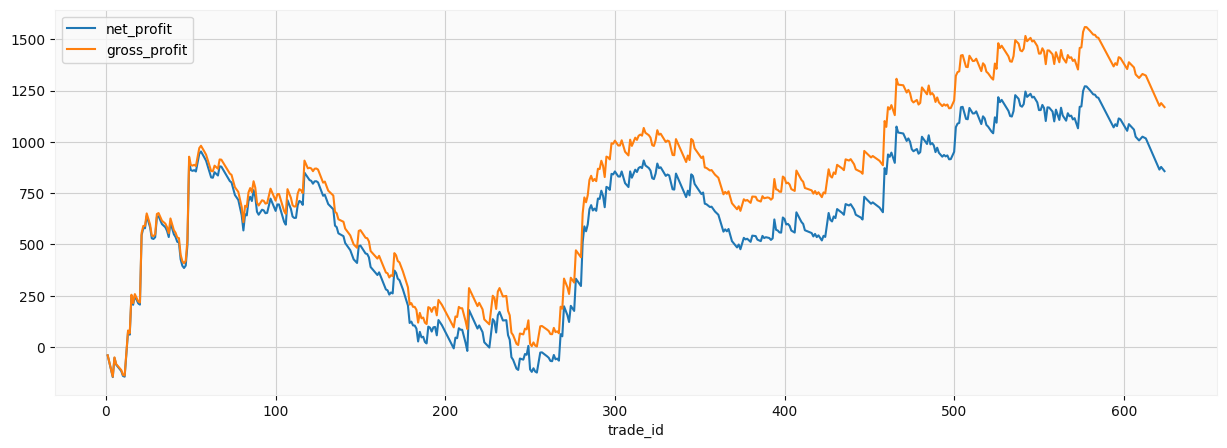

In [18]:
df_trades['net_profit'] = df_trades['gross_profit'] - TRADE_COST
df_trades[['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

In [19]:
df_trades.head(5)

,gross_profit,date_open,date_close,net_profit
trade_id,,,,
1.0,-40.1,2015-01-12 04:00:00,2015-01-12 08:00:00,-40.6
2.0,-38.7,2015-01-22 09:00:00,2015-01-22 13:00:00,-39.2
3.0,-47.1,2015-01-30 11:00:00,2015-01-30 12:00:00,-47.6
4.0,-18.3,2015-02-03 01:00:00,2015-02-03 03:00:00,-18.8
5.0,94.0,2015-02-03 11:00:00,2015-02-04 09:00:00,93.5


In [20]:
report = profit_report_col(df_trades)
for k  in report:
    print(k, '\t  :', report[k])

column 	  : net_profit
tot_trades 	  : 624
tot_win_trades 	  : 184
tot_losing_trades 	  : 440
net_profit 	  : 857.3
win_profit 	  : 8486.3
losing_profit 	  : -7629.0
avg_profit 	  : 1.37
std_profit 	  : 43.93
median_profit 	  : -8.25
mode_profit 	  : -20.3
skew_profit 	  : 3.36


Mean 1.37
Median -8.25


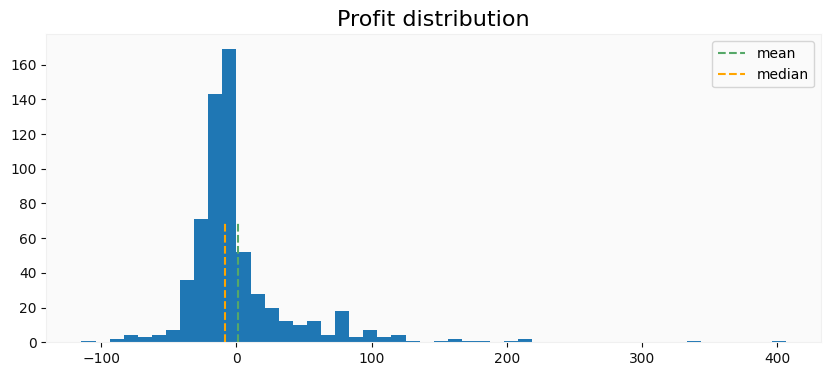

In [21]:
mean_x = report['avg_profit']
median_x = report['median_profit']


print("Mean", mean_x)
print("Median", median_x)

fig, axis=plt.subplots(1,1, figsize=(10,4))
df_trades['net_profit'].hist(grid=False, bins=50)
plt.plot([mean_x, mean_x], [0, 70], color='g', linestyle='--', label='mean')
plt.plot([median_x, median_x], [0, 70], color='orange', linestyle='--', label='median')
plt.legend()
plt.title('Profit distribution', size=16)
plt.show()

**Observations**

Even though the strategy is profitable for the time range back-tested, it is not consistent.

Mainly relies on outliers, which pull the mean (expected profit) to the positive side, but the median (less sensitive to outliers) is negative, showing that the bulk of the trades are in the negative side. A good strategy would have both statistics in the positive side.

All this is confirmed by skewness which is positive indicating a right tailed distribution, which is not good considering median below zero.

What if outliers are removed?. The hypothesis is that this strategy relies only on outliers, and removing them would turn this strategy into a losing one in average, meaning that the average profit should shift to the negative side.

## Results Analysis

### Confidence Interval

Before removing outliers, a confidence interval analysis will be performed on the variable Profit, but as can be seen from the chart above Profits does not show a normal distribution, which is the main assumption for confidence interval calculation and invalidates Profit for this kind of analysis. Recalling the central limit theorem though, a statistic produced from sampling will present a normal distribution if the sample size is large enough (larger than 30) therefore considering sampling mean profit it is possible to move forward with the analysis.
Bootstrapping sampling will be performed to get profits means, but an additional fact needs to be considered: the Profit variable is a time series, and there could be correlations (auto-correlation) between consecutive values.  For example, opening time for trade $t+1$ was affected because trade $t$ was open at the time it should have been opened. Even tough autocorrelation detection is out of the scope of this analysis and for simplicity auto-correlation will be assumed, you can go deeper in some auto-correlation detection techniques like Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF).

For time series bootstrapping there are some techniques, like block bootstrapping, with and without overlapping, among others. To keep things simple block bootstrapping with overlapping will be used in this study. The following image describe in essence what this technique consists of.

 <img src = "BootStrapTS.png" width="700">



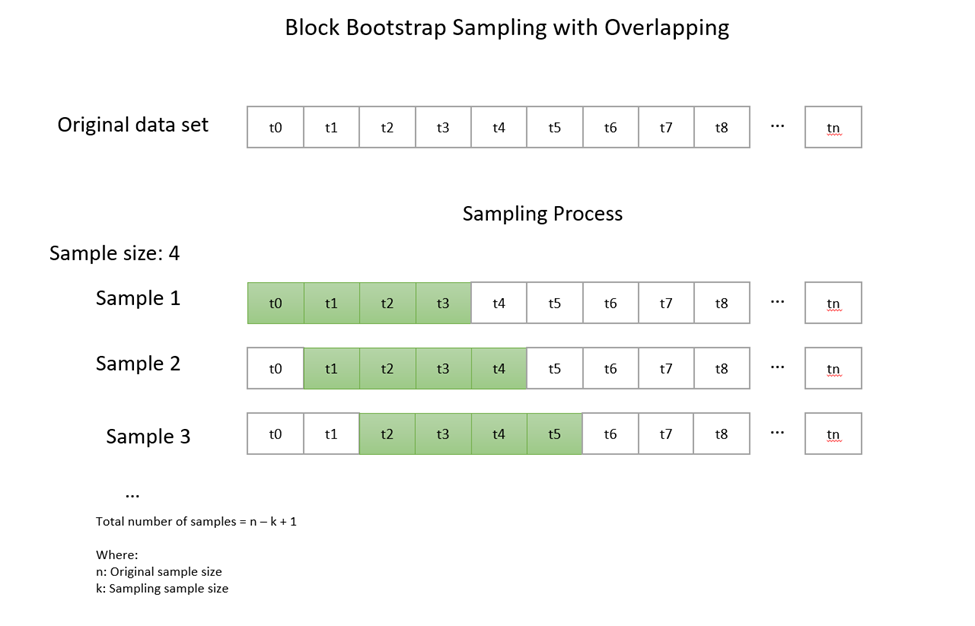

To calculate confidence interval the assumptions are:

* Confidence level: 95 (alpha = 0.05)<br>
* Sample size: 60


In [22]:

alpha = 0.05
bsp = BlockBootStrapSamp()
bsp.compute(df_trades["net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)


 sampling mean: 1.17, 
                    sampling median: 0.25
                    sampling std: 6.42, 
                    sampling standard error: 0.27,
                    sampling min: -13.02,
                    sampling_max: 16.64
confidence interval: [0.64, 1.7], mean: 1.17, standard error: 0.27


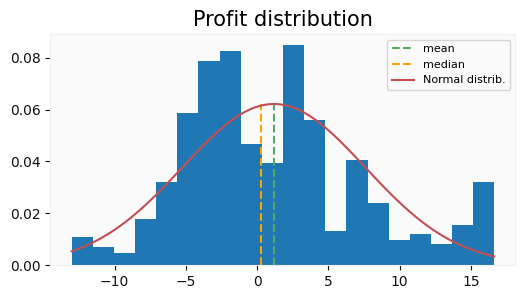

In [23]:
plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)

**Observations**

With this data, we can say that 95% of the times the average profit will be in the range of $[0.64, 1.70]$ pips. This looks good, but do not miss the context: This is affected by outliers and this is sampling mean profit, not the profit itself.

This calculation establish a baseline to compare with same sample after removing outliers which is the next step.



## Removing Outliers

There are many approaches to remove outliers: trimmed mean, values outside confidence intervals and more. For this analysis, two approaches are being taken into consideration: The trading approach and a mathematical approach.

The trading approach considered to remove outliers, is to use trade's risk management tools: Stop Loss and Take Profit. In general terms, Stop Loss controls the loss risk (under a normal market context of volatility not like this context:https://www.dailyfx.com/forex/market_alert/2015/01/15/Swiss-Franc-Skyrockets-as-SNB-Announce-End-of-Currency-Floor.html) and Take Profit, limit the profits (there are many reasons for this that fall out of the scope of this analysis). The advantages of this approach is that no data need to be removed from the sample and makes sense from the trading perspective because stop loss and take profit are simple to apply (implemented in most trading platforms) and will work as expected most of the time.

In the other hand, using mathematical approach to remove outliers like trimming the data (removing data above 90 and below 10 percentiles) for example, in reality are difficult to implement because requires forecasting tools that can predict ahead of time when an outlier will occur, which is complex.

Being that said, the most feasible approach is the trading one, but both will be applied for research purposes and satisfy curiosity.





### Trading Approach

This approach considers applying risk management tools to reduce outliers:  Stop Loss (SL) and Take Profit (TP)
It is out of the scope of this analysis to dive into SL and TP logic. It is assumed that at this point of your trading career you already know about, but in case ou don’t  it is enough to say that SL limit the losses and TP limits the profit and in this context are tools good enough to remove outliers from the trading perspective.
SL levels and TP levels will be set using standard deviation of net profits. SL will be set at one standard deviation and TP will be set at two standard deviations.
This way, the profit range is:

$PR = [-s, 2s]$

Where:

$s$: profit standard deviation


In [24]:

# limit losing trades by stop loss
std_gross_profit = df_trades["gross_profit"].std()

print("Before Removing Outliers : Min profit ", min(df_trades["gross_profit"].values), "max profit ", max(df_trades["gross_profit"].values))
df_trades["limit_gross_profit"] = df_trades["gross_profit"].clip(-std_gross_profit, 2*std_gross_profit)
df_trades["limit_net_profit"] =  df_trades["limit_gross_profit"] - TRADE_COST
print("After Removing Outliers : Min profit ", min(df_trades["limit_gross_profit"].values), "max profit ", max(df_trades["limit_gross_profit"].values))

Before Removing Outliers : Min profit  -114.09999999999921 max profit  406.79999999999825
After Removing Outliers : Min profit  -43.92717752033775 max profit  87.8543550406755


<AxesSubplot:xlabel='trade_id'>

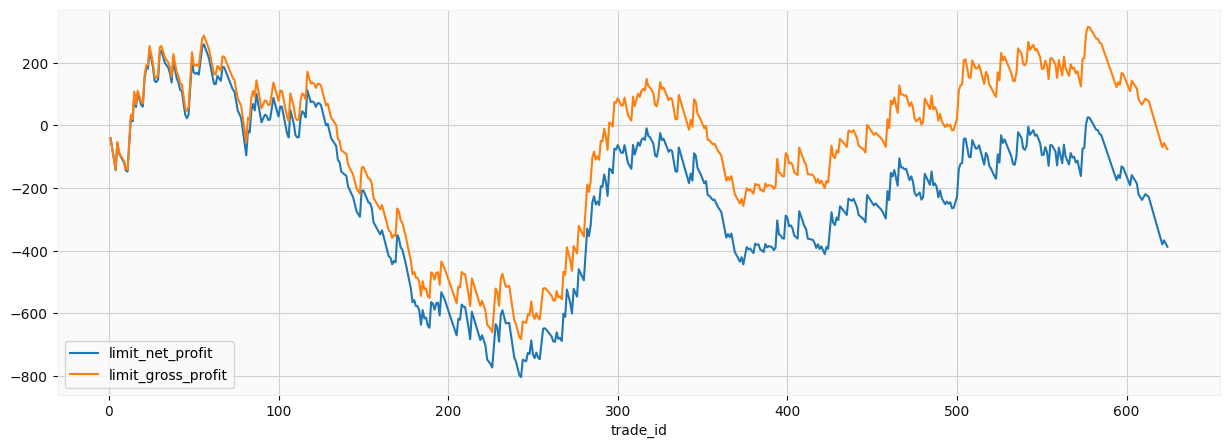

In [25]:
df_trades[['limit_net_profit', 'limit_gross_profit']].cumsum().plot(figsize=(15,5))

 sampling mean: -0.45, 
                    sampling median: -0.98
                    sampling std: 4.77, 
                    sampling standard error: 0.2,
                    sampling min: -11.8,
                    sampling_max: 11.94
confidence interval: [-0.84, -0.06], mean: -0.45, standard error: 0.2


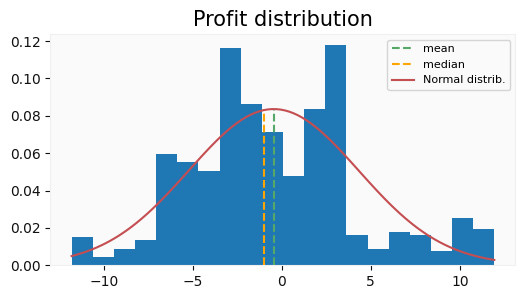

In [26]:
alpha = 0.05
bsp = BlockBootStrapSamp()
bsp.compute(df_trades["limit_net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)

plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)


**Observations**

Limiting loss and profits to remove outliers so the trading strategy will not rely on them, it is possible to appreciate that the profit mean now lays within a negative range for a confidence level of 95%.

This supports the hypothesis that this trading strategy is not a good one because relies only on outliers.


### Mathematical Approach

The mathematical approach trims the outliers by removing the profits above 90 percentile and below 10 percentile.

In [27]:
mask_10_off = (df_trades['gross_profit'] >= df_trades['gross_profit'].quantile(.1)) & (df_trades['gross_profit'] <= df_trades['gross_profit'].quantile(.95))
df_trades.loc[mask_10_off, "trimmed_gross_profit"] = df_trades[mask_10_off]['gross_profit']
df_trades["trimmed_net_profit"] = df_trades[mask_10_off]['trimmed_gross_profit'] - TRADE_COST

<AxesSubplot:xlabel='trade_id'>

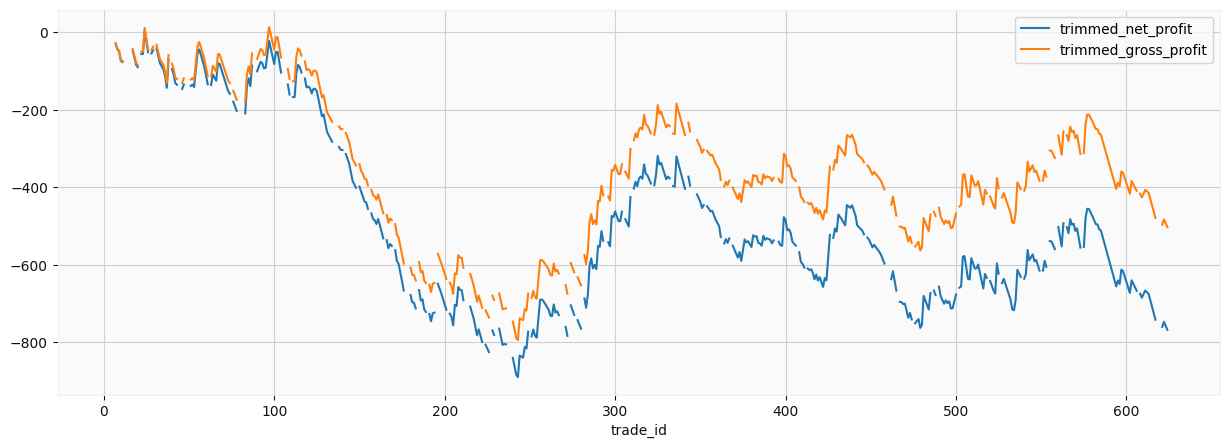

In [28]:
df_trades[['trimmed_net_profit', 'trimmed_gross_profit']].cumsum().plot(figsize=(15,5))

 sampling mean: -1.06, 
                    sampling median: -1.04
                    sampling std: 3.88, 
                    sampling standard error: 0.18,
                    sampling min: -10.11,
                    sampling_max: 8.29
confidence interval: [-1.41, -0.71], mean: -1.06, standard error: 0.18


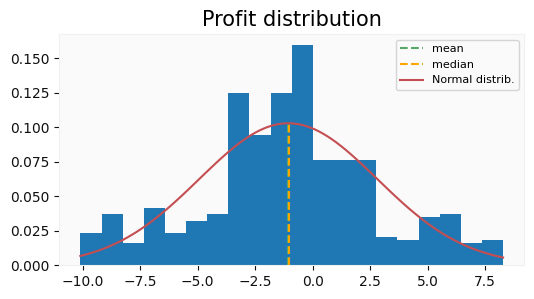

In [29]:
alpha = 0.05
bsp = BlockBootStrapSamp()
bsp.compute(df_trades[mask_10_off]["trimmed_net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)

plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)

# confidence_interval_analysis(df_trades["trimmed_net_profit"].dropna(), 60)

**Observations**

The main observations is that as well as limiting profit and losses, this method fore removing outliers, moves the mean profit towards a negative confidence interval with a 95% confidence level.

As a secondary observation, removing outliers instead of limiting values, gets the values of mean an median closer.



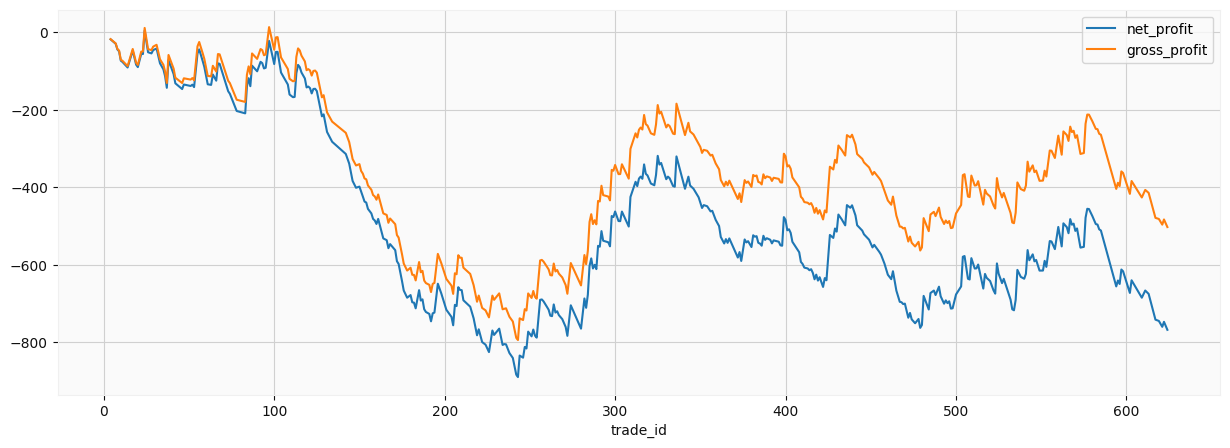

In [30]:

df_trades[mask_10_off][['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

Clearly, from cumulative profit chart, is possible to verify that removed outliers has impacted the strategy perofrmance, but the question that remains is: is this impact staisticaly significant?